In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from sklearn.linear_model import LinearRegression
import datetime as dt
sb.set() # set the default Seaborn style for graphics

For our prediction model, we plan to use a three step approach to ensure that the customers are exposed to novel articles and yet also make use of their past transactions in this decision making. This is done in the following steps:

1. Choosing top 100 most popular articles by customer age group
2. Choosing the most important and popular attributes based on ALL customers' transactions within timeframe
3. Use Image Processing to recommend similar styles for customer

### Extracting Transaction Data

In [2]:
transactiondata = pd.read_csv('transactions.csv')
transactiondata = transactiondata.loc[:, ~transactiondata.columns.str.contains('^Unnamed')]
transactiondata.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-01-02,00025f8226be50dcab09402a2cacd520a99e112fe01fdd...,797565002,0.030492,2
1,2020-01-02,00025f8226be50dcab09402a2cacd520a99e112fe01fdd...,797565001,0.030492,2
2,2020-01-02,00067622de3151a7219b4ed9922def50b51601fbe41418...,801865004,0.018627,1
3,2020-01-02,0010f56acce349e6e82bfef13ee39232a8bc0db0801ca4...,578752001,0.020322,2
4,2020-01-02,0010f56acce349e6e82bfef13ee39232a8bc0db0801ca4...,578752001,0.020339,2


### Choosing random customer id for prediction

In [3]:
targetcustomerid = transactiondata.iloc[50000]['customer_id']

### Initial Data Cleaning

In [4]:
transactiondf = transactiondata.loc[:,['t_dat', 'customer_id', 'article_id']]
transactiondf.loc[:,'t_dat'] = pd.to_datetime(transactiondf['t_dat'], format='%Y-%m-%d')

max_dat = transactiondf['t_dat'].max()
transactiondf['max_dat'] = max_dat
transactiondf['diff_dat'] = (transactiondf.max_dat - transactiondf.t_dat).dt.days
transactiondf.head()

,t_dat,customer_id,article_id,max_dat,diff_dat
0,2020-01-02,00025f8226be50dcab09402a2cacd520a99e112fe01fdd...,797565002,2020-09-22,264
1,2020-01-02,00025f8226be50dcab09402a2cacd520a99e112fe01fdd...,797565001,2020-09-22,264
2,2020-01-02,00067622de3151a7219b4ed9922def50b51601fbe41418...,801865004,2020-09-22,264
3,2020-01-02,0010f56acce349e6e82bfef13ee39232a8bc0db0801ca4...,578752001,2020-09-22,264
4,2020-01-02,0010f56acce349e6e82bfef13ee39232a8bc0db0801ca4...,578752001,2020-09-22,264


### Get CustomerDF within required age range

In [5]:
customerdata = pd.read_csv('customers.csv', usecols=['customer_id', 'age'])
age = customerdata.loc[customerdata['customer_id'] == targetcustomerid]['age'].astype({'age': 'int64'}).values[0]
quotient = age // 10
minage = quotient * 10
maxage = (quotient+1) * 10
scopedCustomerData = customerdata.loc[(customerdata['age'] > minage) & (customerdata['age'] < maxage)]
scopedCustomerData.head()

,customer_id,age
31,00018385675844f7a6babbed41b5655b5727fb16483b6e...,68.0
93,000412345109c7c085b5faec96afe864b19a172fa4cb9b...,63.0
106,00048f2f68760664d2d0fa1e7fbfe083f05287f342484c...,67.0
172,000747860042b94e85707605c2a627c6ba30c4117d025d...,62.0
309,000eae69313b4fc1824fa7e439f168cc140bf4c3f3a7e9...,67.0


### Merge scopedCustomerData with transactiondf on customer_id and find transactions within recent 90 days

In [6]:
mergeddf = scopedCustomerData.merge(transactiondf, on=['customer_id'], how='left')
mergeddfInDateRange = mergeddf.loc[(mergeddf['diff_dat'] <90)]
mergeddfInDateRange.head()

,customer_id,age,t_dat,article_id,max_dat,diff_dat
30,000eae69313b4fc1824fa7e439f168cc140bf4c3f3a7e9...,67.0,2020-07-08,562245018.0,2020-09-22,76.0
31,000eae69313b4fc1824fa7e439f168cc140bf4c3f3a7e9...,67.0,2020-07-08,562245088.0,2020-09-22,76.0
32,000eae69313b4fc1824fa7e439f168cc140bf4c3f3a7e9...,67.0,2020-07-10,720125041.0,2020-09-22,74.0
33,000eae69313b4fc1824fa7e439f168cc140bf4c3f3a7e9...,67.0,2020-07-10,562245018.0,2020-09-22,74.0
37,000f1c4a03223d999d3c6d3703e247dba81d6dacb3dbfb...,62.0,2020-06-25,817472005.0,2020-09-22,89.0


# Step 1: Find top 100 articles from mergedDF based on purchase count for all customers

In [7]:
article_id_count = mergeddfInDateRange.groupby('article_id')['age'].count()
article_id_count

temp = mergeddfInDateRange.groupby(['article_id'])['age'].count()
tempdf = pd.DataFrame({'Article ID': temp.index,
                   'Count': temp.values
                  })
articlesCount = tempdf.sort_values(['Count'], ascending=False)
tophundredarticles = articlesCount.head(100)
tophundredarticles = tophundredarticles.astype({'Article ID': 'int64'})

tophundredarticles.head()

,Article ID,Count
14986,896152002,328
10920,856840001,321
14993,896169002,222
5784,783346001,205
14987,896152003,195


### i) Get Attributes of top 100 articles 

In [8]:
articlesdata = pd.read_csv('articles.csv')
selectedArticlesAttributes = articlesdata.loc[(articlesdata['article_id'].isin(tophundredarticles['Article ID']))]
selectedArticlesAttributes.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
2252,399256001,399256,Skinny Ankle R.W Brooklyn,272,Trousers,Garment Lower body,1010016,Solid,9,Black,...,Everyday Waredrobe Denim,A,Ladieswear,1,Ladieswear,57,Ladies Denim,1016,Trousers Denim,Ankle-length jeans in washed stretch denim wit...
2255,399256005,399256,Skinny Ankle R.W Brooklyn,272,Trousers,Garment Lower body,1010016,Solid,10,White,...,Everyday Waredrobe Denim,A,Ladieswear,1,Ladieswear,57,Ladies Denim,1016,Trousers Denim,Ankle-length jeans in washed stretch denim wit...
12724,554598001,554598,Nora T-shirt,255,T-shirt,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,"T-shirt in soft jersey with a round neck, shor..."
12726,554598003,554598,Nora T-shirt,255,T-shirt,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,"T-shirt in soft jersey with a round neck, shor..."
17043,572797001,572797,ESSENTIAL TANKTOP LACE TVP,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey,A,Ladieswear,1,Ladieswear,6,Womens Casual,1005,Jersey Fancy,Fitted vest top in soft cotton jersey with lac...


### ii) Return top attributes of articles bought by all customers within date range

In [9]:
characteristic_list = ['article_id', 'product_type_name', 'product_group_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name']
articles_df = articlesdata[characteristic_list]

df = transactiondata.loc[:,['t_dat', 'customer_id', 'article_id']]
df.loc[:,'t_dat'] = pd.to_datetime(df['t_dat'], format='%Y-%m-%d')
# max_date_bound = df.t_dat.max()
# print(max_date_bound)
# df = df[(df.customer_id == targetcustomerid) & ((max_date_bound - df.t_dat).dt.days <= 90)]
df = df.merge(articles_df, on=['article_id'], how='left')

# category = 'product_type_name'

# x.index[0]
# x.values[1][0]
characteristic_count = []
for category in characteristic_list[1:]:
    results_df = pd.DataFrame(df[category].value_counts())
    for i in range(len(results_df.index)):
        result = [category, results_df.index[i], results_df.values[i][0]]
#         print(result)
        characteristic_count.append(result)

characteristic_count_df = pd.DataFrame(characteristic_count, columns = ['Category', 'Value', 'Count'])

characteristic_count_df = characteristic_count_df.sort_values('Count', ascending=False)
idx = characteristic_count_df.groupby(['Category'], sort=False)['Count'].transform(max) == characteristic_count_df['Count']
topcharacteristics = characteristic_count_df[idx]
topcharacteristics

,Category,Value,Count
508,index_group_name,Ladieswear,7298657
146,graphical_appearance_name,Solid,6567800
226,perceived_colour_value_name,Dark,4779924
498,index_name,Ladieswear,4494305
127,product_group_name,Garment Upper body,3936958
234,perceived_colour_master_name,Black,3641700
176,colour_group_name,Black,3622888
513,section_name,Womens Everyday Collection,1941409
569,garment_group_name,Jersey Fancy,1840692
0,product_type_name,Trousers,1398844


### iii) Combine Steps 1 and 2 to select Articles that are the top 100 in customer age group and possess the most characteristics of popular articles

In [10]:
oldArticlesAttributes = selectedArticlesAttributes
for index, row in topcharacteristics.iterrows():
  category = row[0]
  value = row[1]
  selectedArticlesAttributes = selectedArticlesAttributes.loc[selectedArticlesAttributes[category] == value]
  if selectedArticlesAttributes.empty:
    selectedArticlesAttributes = oldArticlesAttributes
  oldArticlesAttributes = selectedArticlesAttributes
    
selectedArticlesAttributes

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
94674,863595006,863595,Baraboom throw-on,245,Cardigan,Garment Upper body,1010016,Solid,9,Black,...,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,"Long cardigan in a soft, fine knit containing ..."
94696,863646001,863646,Matey,252,Sweater,Garment Upper body,1010016,Solid,9,Black,...,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,"Wide, V-neck jumper in a knit containing some ..."
101367,896152002,896152,Amelie,255,T-shirt,Garment Upper body,1010016,Solid,9,Black,...,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,"Top in a soft, fine knit containing some wool ..."
103794,915526002,915526,Nika vest,252,Sweater,Garment Upper body,1010016,Solid,9,Black,...,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,"Relaxed-fit slipover in a soft, rib-knit cotto..."


### Find Mean Price of selected Articles

In [11]:
meanPriceDF = pd.DataFrame(columns = ['article_id', 'meanPrice'])
for index, row in selectedArticlesAttributes.iterrows():
    article_id = row[0]
    pricedf = transactiondata.loc[transactiondata['article_id'] == article_id]
    meanPrice = pricedf['price'].mean()
    newDF = pd.DataFrame({'article_id': [article_id],
                    'meanPrice' : [meanPrice]})
    meanPriceDF = pd.concat([newDF, meanPriceDF], ignore_index = True, axis = 0)

display(meanPriceDF)

,article_id,meanPrice
0,915526002,0.032929
1,896152002,0.032986
2,863646001,0.033337
3,863595006,0.033104


# Step 2: Linear Regression Model to find the trend of customer spending

In [12]:
customerspendingdf = transactiondata.loc[transactiondata['customer_id'] == targetcustomerid]
customerspendingdf.head()

,t_dat,customer_id,article_id,price,sales_channel_id
50000,2020-01-03,1c9db31372977fa5281362cae3cf8d976c00c60b6ec910...,845790002,0.033881,2
203081,2020-01-07,1c9db31372977fa5281362cae3cf8d976c00c60b6ec910...,724773005,0.059305,2
1354261,2020-02-09,1c9db31372977fa5281362cae3cf8d976c00c60b6ec910...,840604002,0.025407,2
1354262,2020-02-09,1c9db31372977fa5281362cae3cf8d976c00c60b6ec910...,783346001,0.025407,2
2474697,2020-03-11,1c9db31372977fa5281362cae3cf8d976c00c60b6ec910...,855200005,0.033881,2


### Use mean purchase intervals to predict customer's expected next purchase date

In [13]:
totaldatedifferences = 0
for i in range(1, len(customerspendingdf)):
    oldrow = i - 1
    olddate = pd.to_datetime(customerspendingdf.iloc[[oldrow]]['t_dat'].values[0], format='%Y-%m-%d')
    newdate = pd.to_datetime(customerspendingdf.iloc[[i]]['t_dat'].values[0], format='%Y-%m-%d')
    datediff = (newdate - olddate).days
    totaldatedifferences = totaldatedifferences + datediff
meandatedifferences = int(totaldatedifferences/ len(customerspendingdf))
customerspendingdf['t_dat']= pd.to_datetime(customerspendingdf['t_dat'])
newpurchasedate = customerspendingdf.iloc[-1]['t_dat'] + pd.DateOffset(days = meandatedifferences)
newpurchasedate = newpurchasedate.toordinal()
newpurchasedate

<ipython-input-13-f7c90ad0514c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customerspendingdf['t_dat']= pd.to_datetime(customerspendingdf['t_dat'])


737700

### Use Linear Regression to predict expected price of next purchase

In [15]:
# Recall the Total-HP Dataset
price = pd.DataFrame(customerspendingdf['price'])           # Response
dates = pd.DataFrame(customerspendingdf['t_dat'])         # Predictor
dates['t_dat'] = (dates['t_dat'].apply(lambda date: date.toordinal()))
newpurchasedatedf = pd.DataFrame([newpurchasedate], columns=['t_dat'])

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(dates, price)        # train the linear regression model

result = linreg.predict(newpurchasedatedf)
expectedPriceOfNextPurchase = result[0][0]
expectedPriceOfNextPurchase

0.02399118746801321

### Find article with mean price closest to expected price

In [16]:
meanPriceDF['price_diff'] = (meanPriceDF.meanPrice - expectedPriceOfNextPurchase)
meanPriceDF[meanPriceDF['meanPrice']==meanPriceDF['meanPrice'].min()]

,article_id,meanPrice,price_diff
0,915526002,0.032929,0.008938


# Step 3: Additional reccomendations from previously trained feature map

## 1st 50K articles

In [29]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
from PIL import Image
import pickle
from datetime import datetime
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
#import streamlit as st
#use the below library while displaying the images in jupyter notebook
from IPython.display import display, Image

In [30]:
articles = pd.read_csv('./articles.csv')
a_copy = articles.copy()
df_Productids = list(a_copy['article_id'])

In [31]:
extracted_features = np.load('/Users/danielyang/Desktop/DSAI Lab/hm_50k.npy')
Productids1 = np.load('/Users/danielyang/Desktop/DSAI Lab/hm_product_ids_50k.npy')
Productids1 = list(Productids1)
def get_similar_products_cnn1(product_id, num_results):
    doc_id = Productids1.index(product_id)
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1,-1))
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    print("="*20, "input product image", "="*20)
    ip_row = a_copy[['article_id','prod_name']].loc[a_copy['article_id']==int(Productids1[indices[0]])]
#     print(ip_row.head())
    for indx, row in ip_row.iterrows():
        display(Image(filename = "/Users/danielyang/Downloads/h-and-m-personalized-fashion-recommendations/images/" + str(product_id)[0:3]+'/'+str(product_id)+'.jpg', width = 224, height = 224,embed=True))
        print('Product Title: ', row['prod_name'])
    print("\n","="*20, "Recommended products", "="*20)
    for i in range(1,len(indices)):
        rows = a_copy[['article_id','prod_name']].loc[a_copy['article_id']==int(Productids1[indices[i]])]
#         print(rows)
        for indx, row in rows.iterrows():
            display(Image(filename = "/Users/danielyang/Downloads/h-and-m-personalized-fashion-recommendations/images/" + '0' + str(row['article_id'])[0:2] +'/'+ "0" +str(row['article_id'])+'.jpg', width = 224, height = 224,embed=True))
            print('Product Title: ', row['prod_name'])
            print('Euclidean Distance from input image:', pdists[i])

## 50K - 105k articles

In [32]:
extracted_features = np.load('/Users/danielyang/Desktop/DSAI Lab/57k_features_2.npy')
Productids2 = np.load('/Users/danielyang/Desktop/DSAI Lab/57k_ids_2.npy')
Productids2 = list(Productids2)
def get_similar_products_cnn2(product_id, num_results):
    doc_id = Productids2.index(product_id)
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1,-1))
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    print("="*20, "input product image", "="*20)
    ip_row = a_copy[['article_id','prod_name']].loc[a_copy['article_id']==int(Productids2[indices[0]])]
#     print(ip_row.head())
    for indx, row in ip_row.iterrows():
        display(Image(filename = "/Users/danielyang/Downloads/h-and-m-personalized-fashion-recommendations/images/" + str(product_id)[0:3]+'/'+str(product_id)+'.jpg', width = 224, height = 224,embed=True))
        print('Product Title: ', row['prod_name'])
    print("\n","="*20, "Recommended products", "="*20)
    for i in range(1,len(indices)):
        rows = a_copy[['article_id','prod_name']].loc[a_copy['article_id']==int(Productids2[indices[i]])]
#         print(rows)
        for indx, row in rows.iterrows():
            display(Image(filename = "/Users/danielyang/Downloads/h-and-m-personalized-fashion-recommendations/images/" + '0' + str(row['article_id'])[0:2] +'/'+ "0" +str(row['article_id'])+'.jpg', width = 224, height = 224,embed=True))
            print('Product Title: ', row['prod_name'])
            print('Euclidean Distance from input image:', pdists[i])

==================== input product image ====================


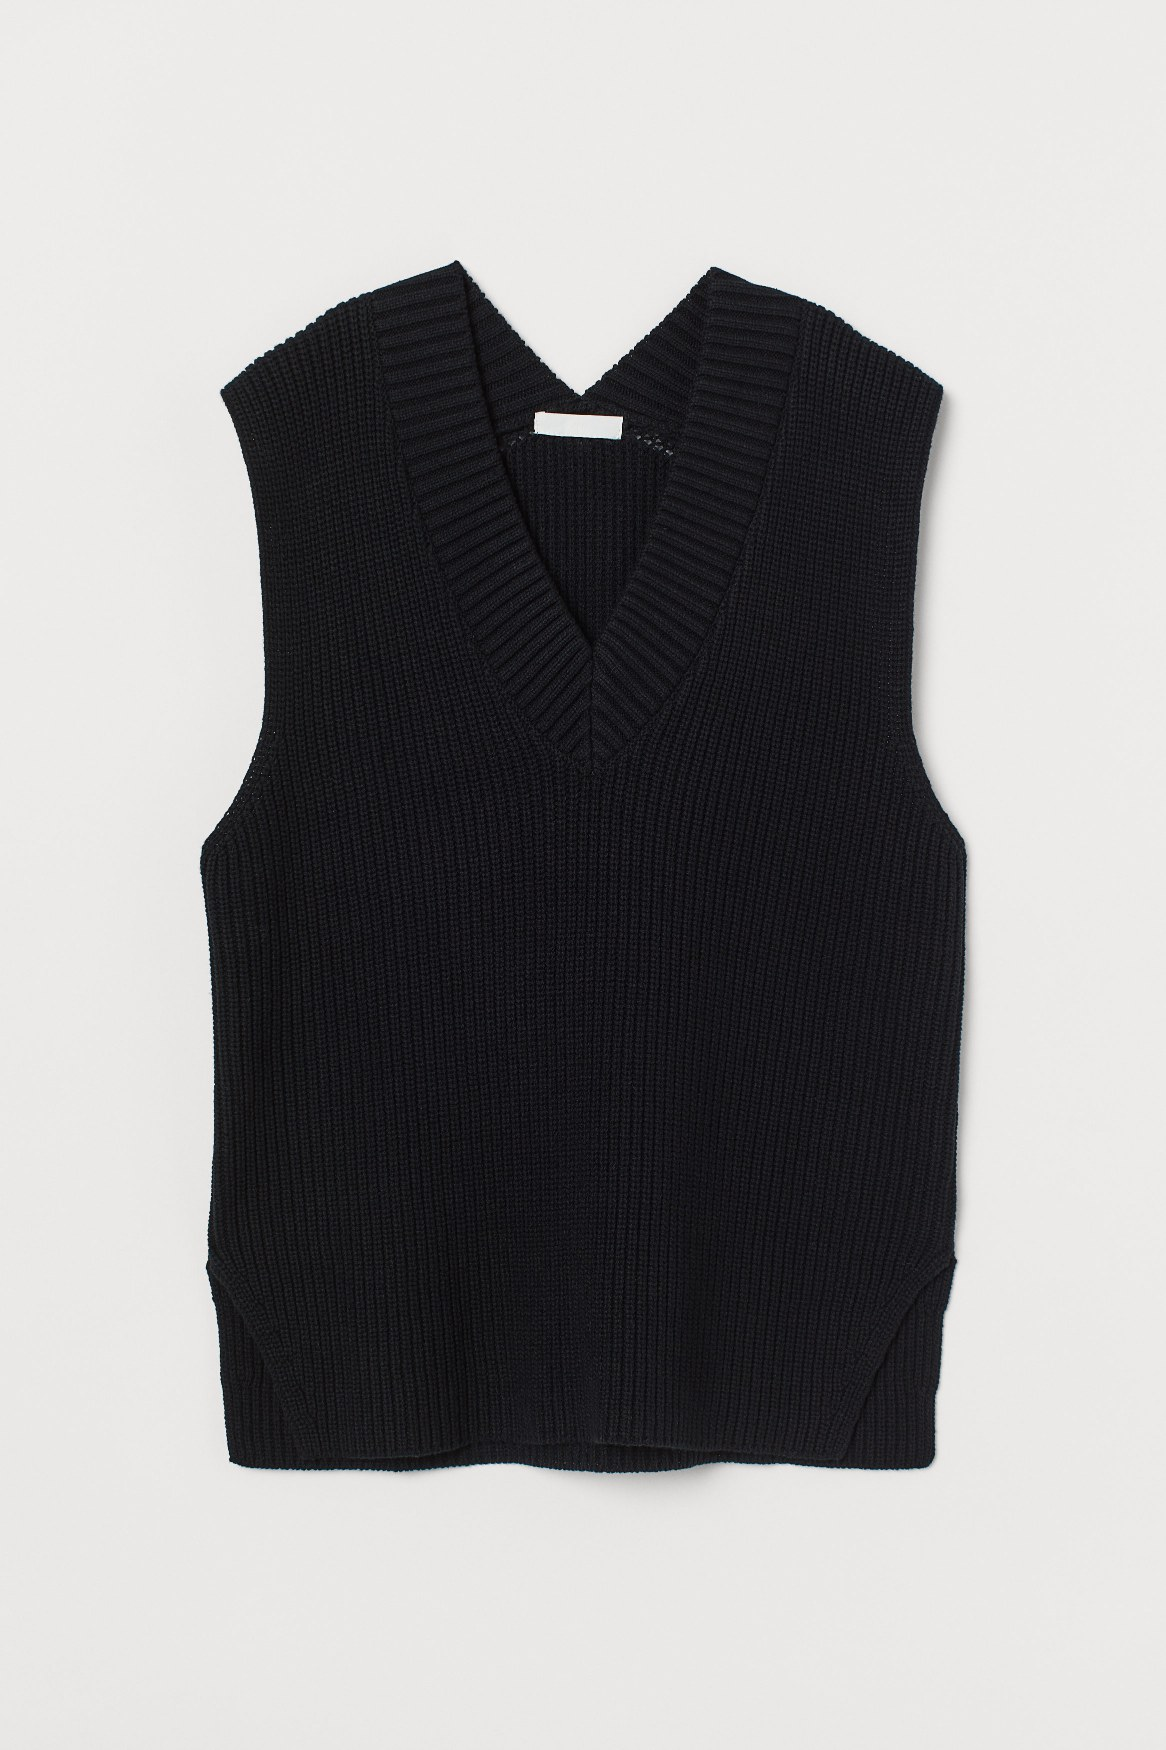

Product Title:  Nika vest

 ==================== Recommended products ====================


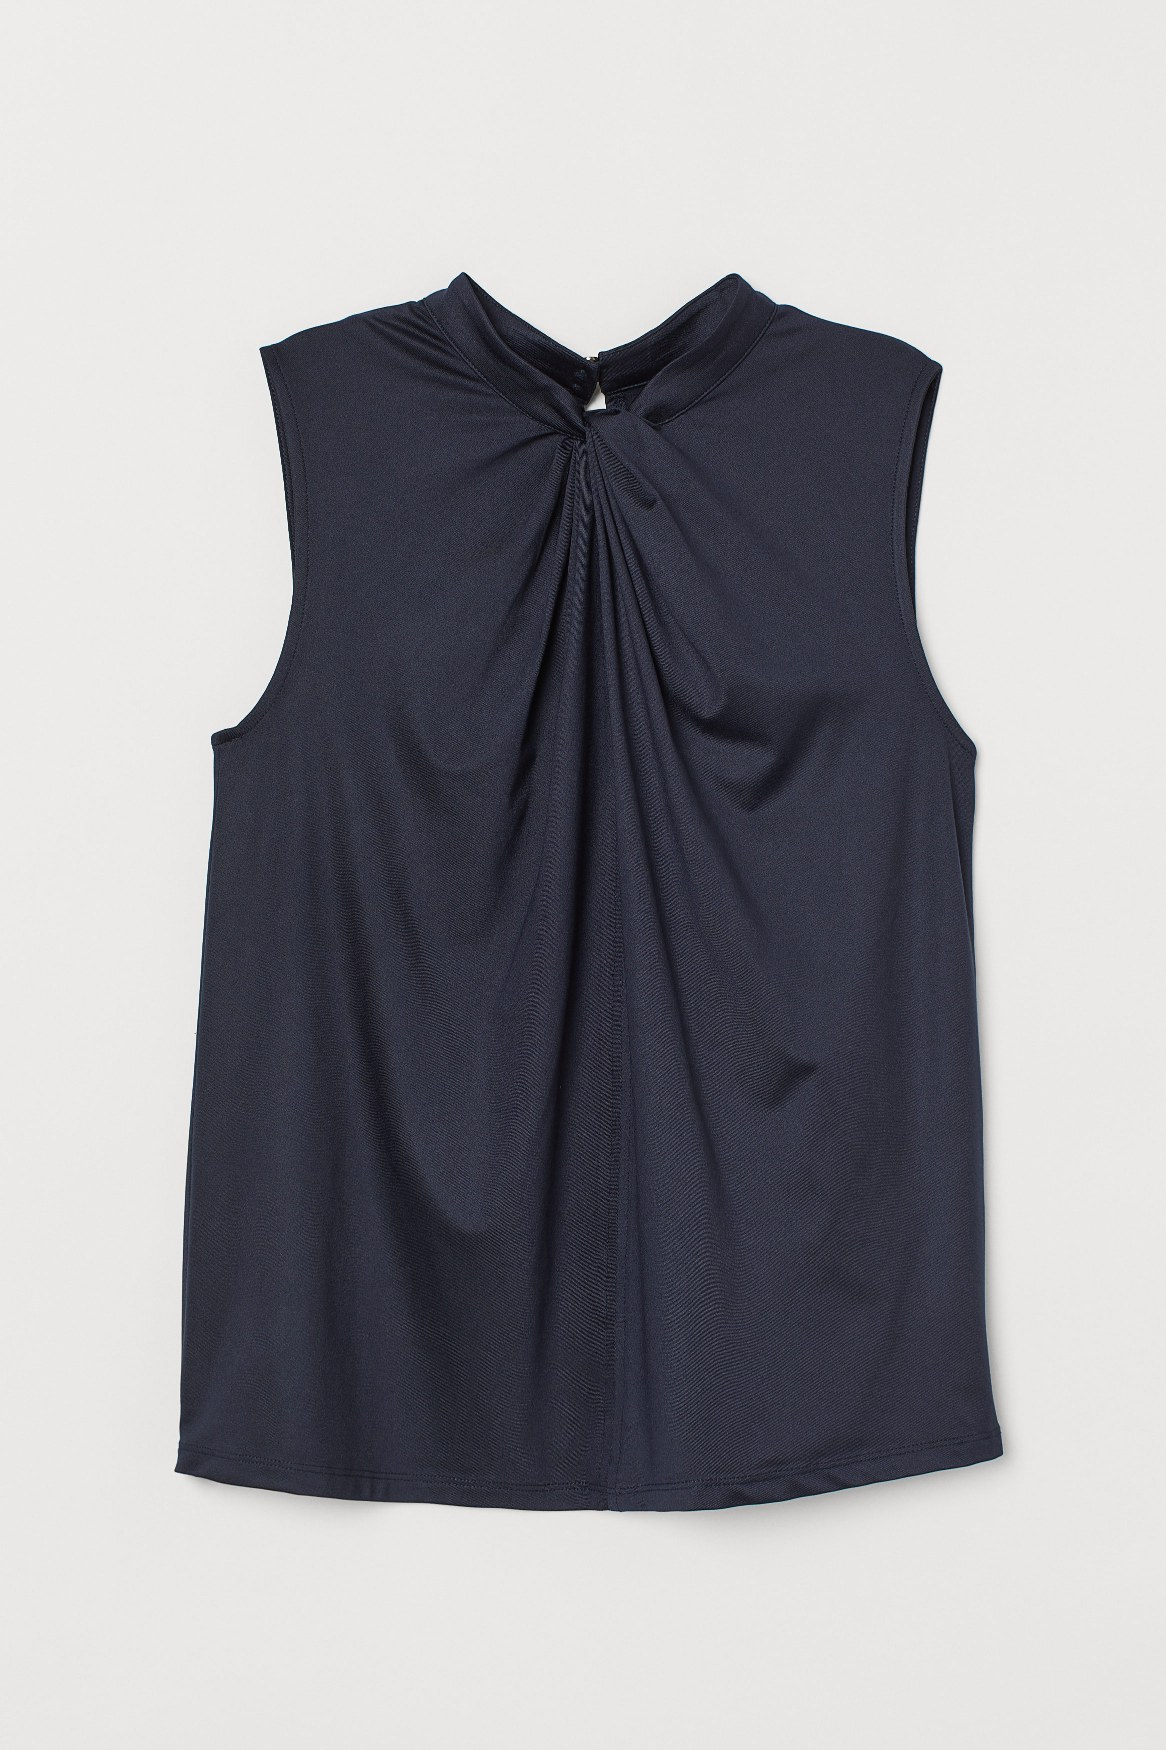

Product Title:  Tiguan top TR
Euclidean Distance from input image: 24.832783


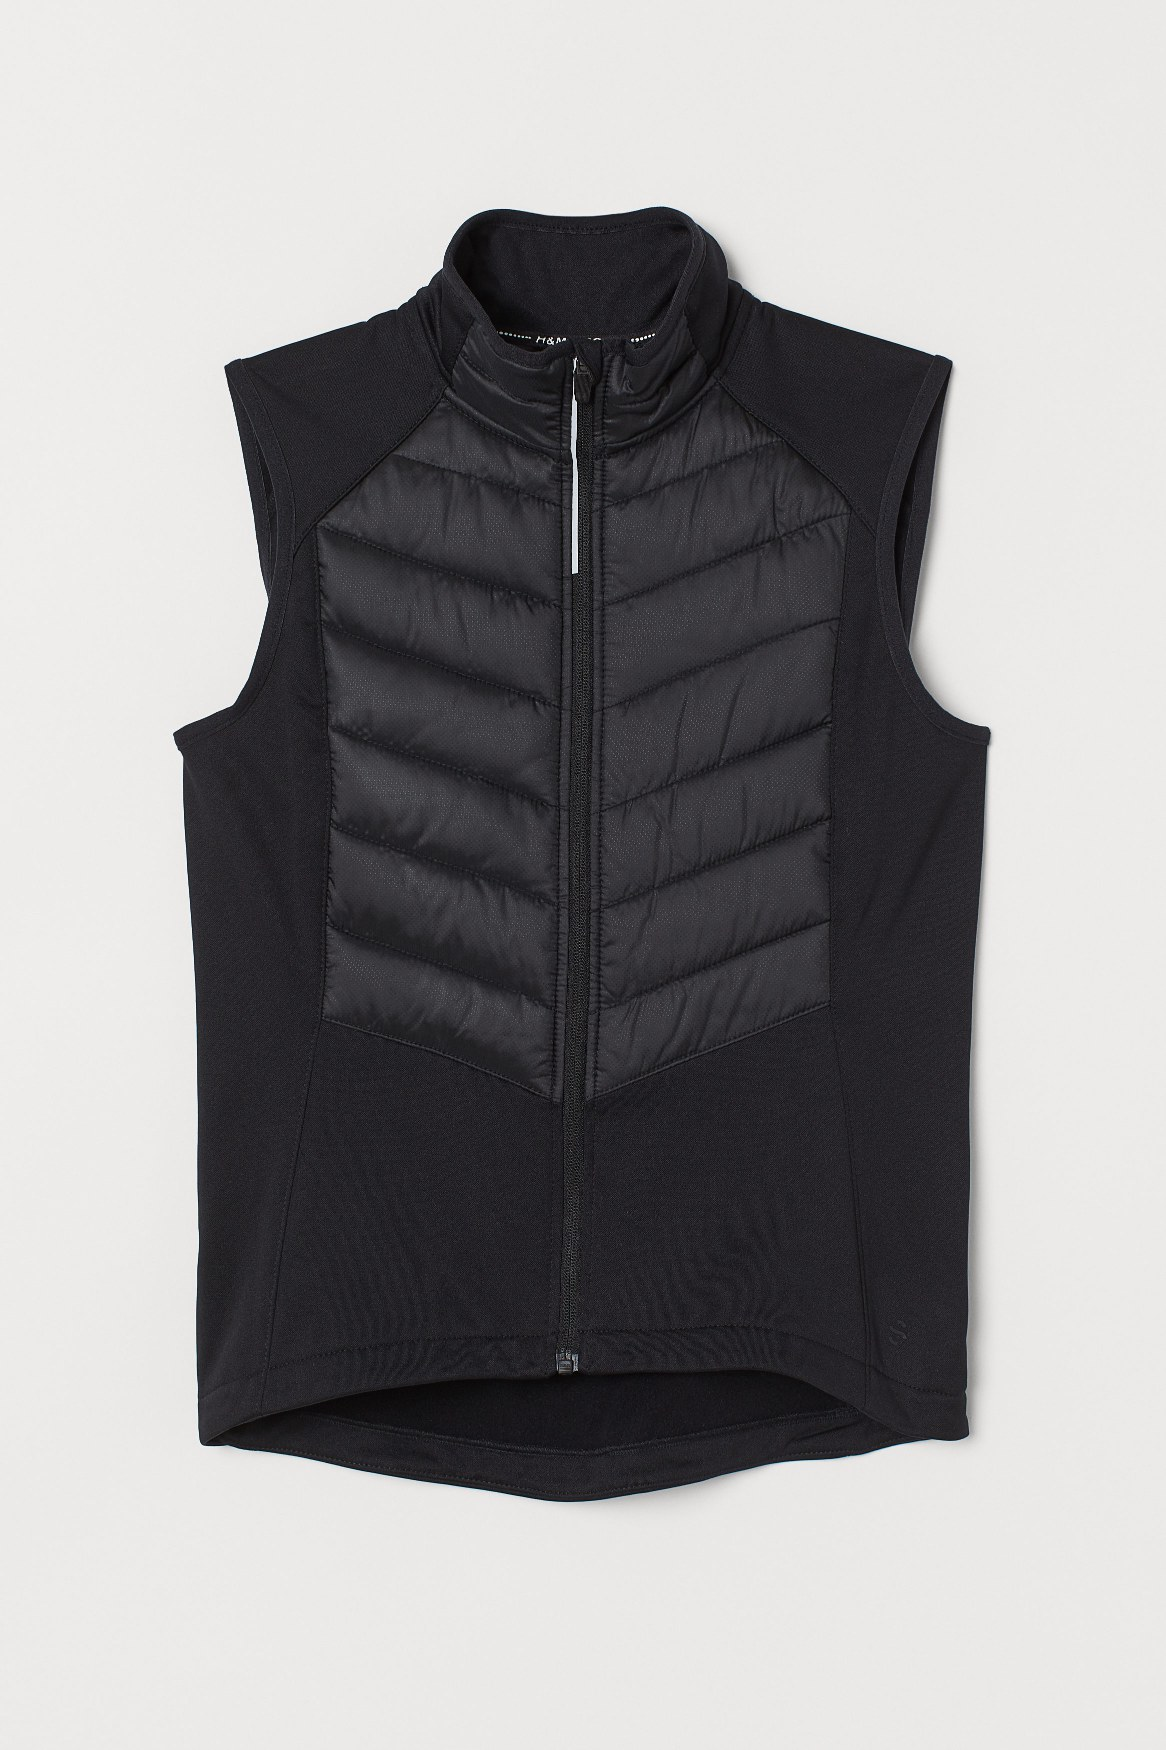

Product Title:  ROX Vest
Euclidean Distance from input image: 25.732126


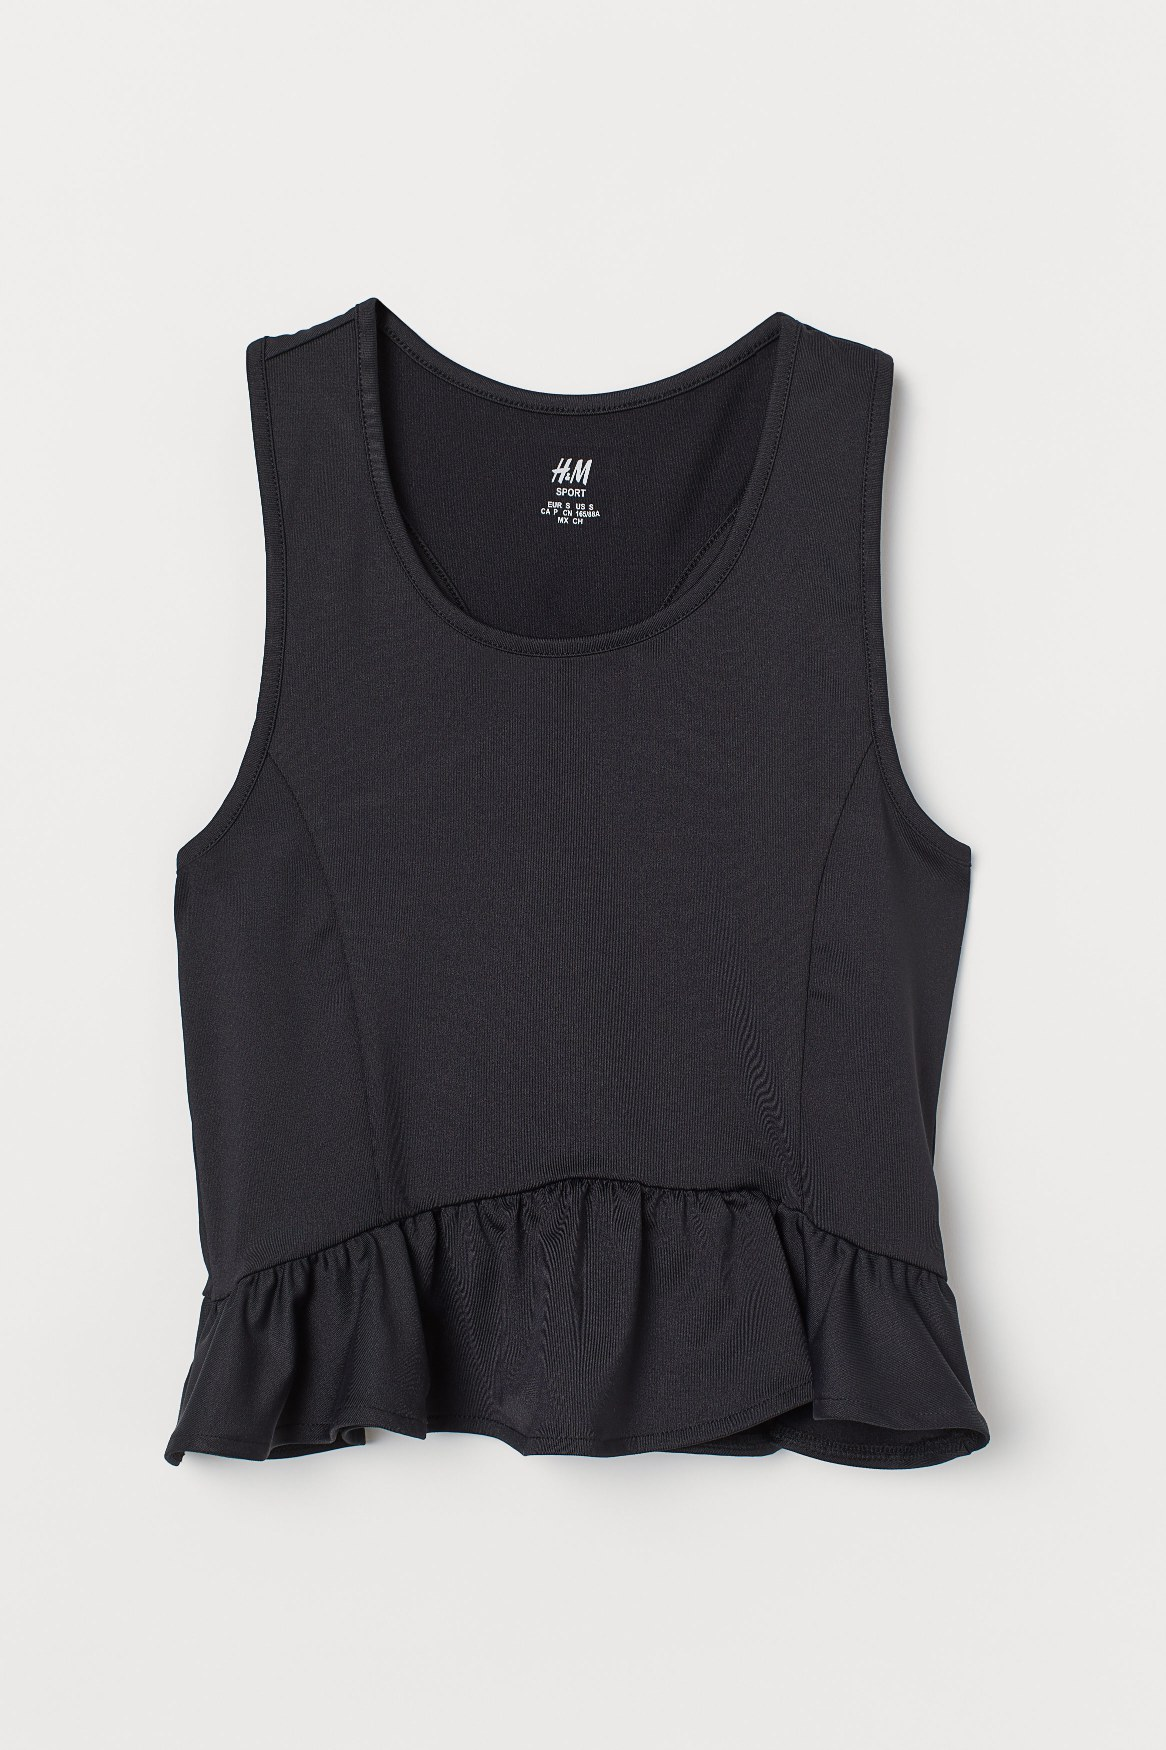

Product Title:  Cancun frill top
Euclidean Distance from input image: 25.865097


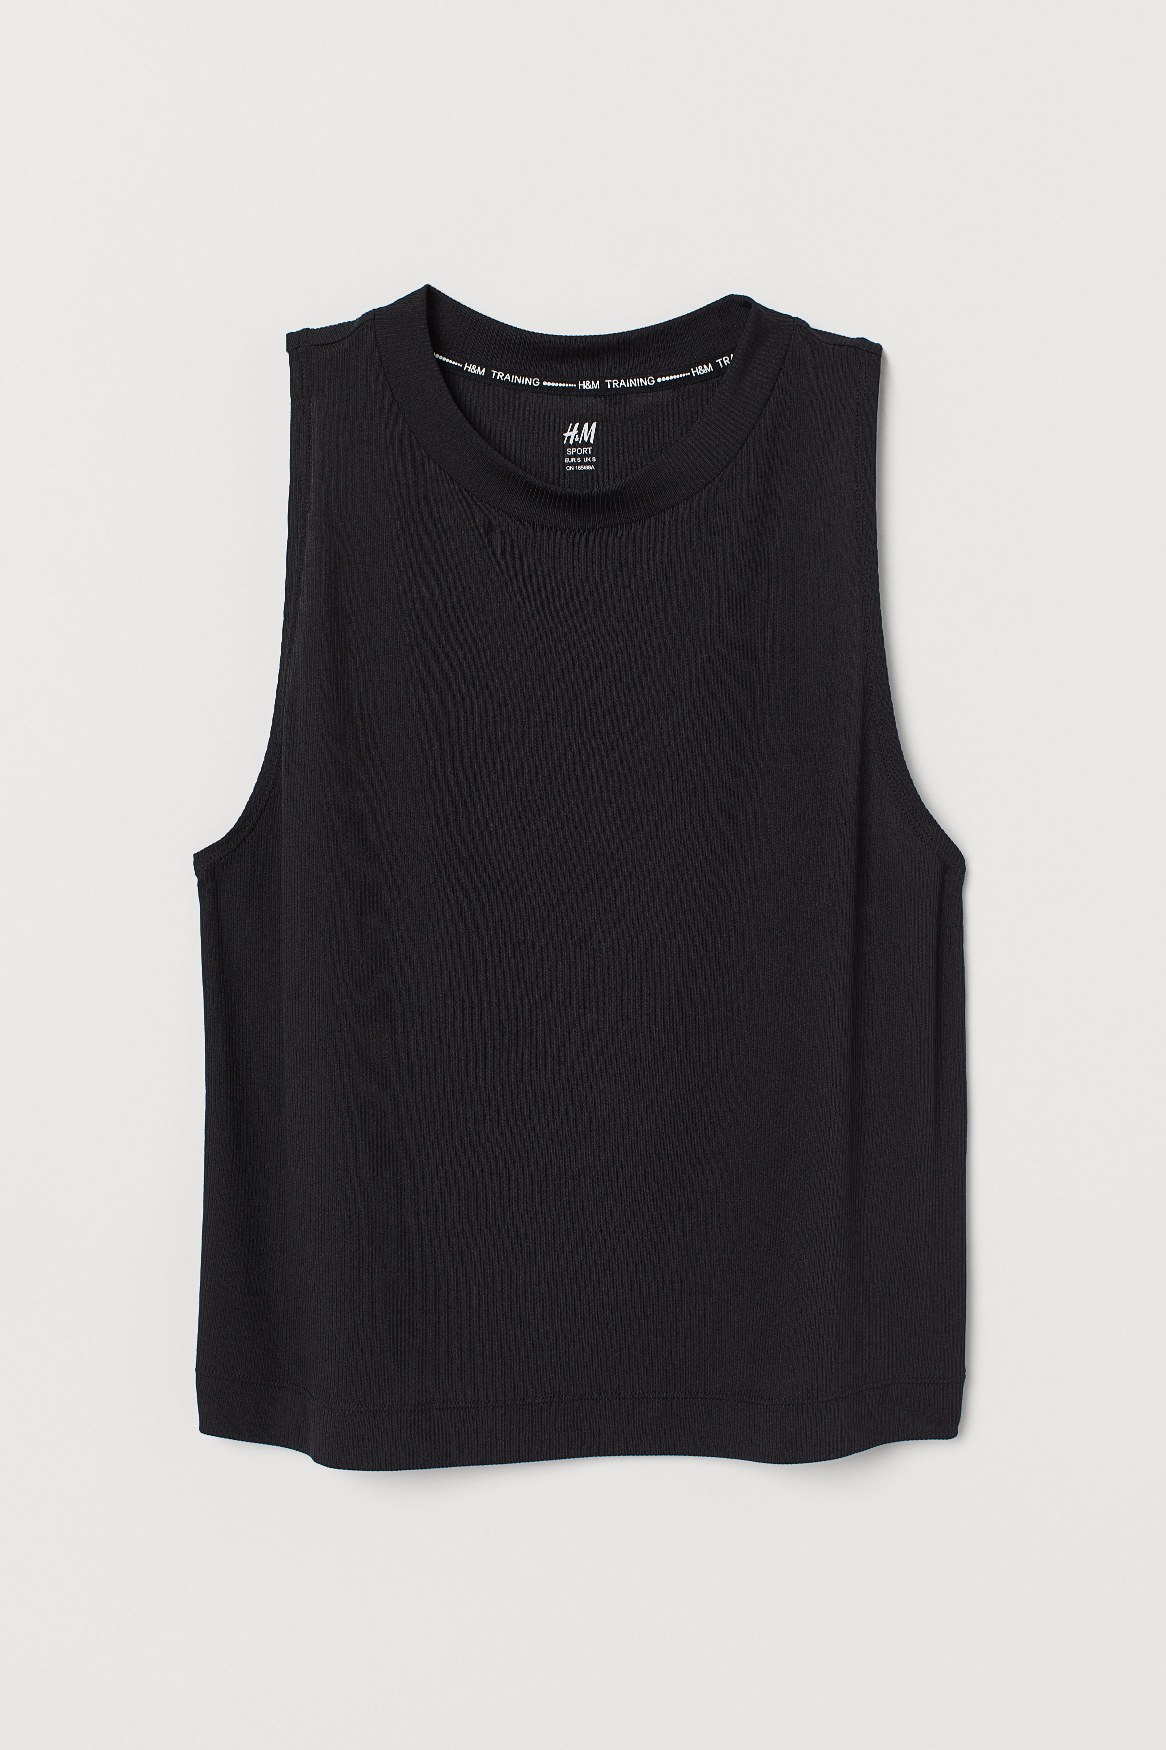

Product Title:  Dexter Rib Tank
Euclidean Distance from input image: 26.521927


In [33]:
get_similar_products_cnn2('0915526002', 5)